# Calculating handicaps for WOBYC dinghy racing
This notebook was originally created for Waveney and Oulton Broad Yacht Club to demonstrate the calculation of a personalised handicap for the Oulton Rater XX2, for use in club dinghy racing. The data for XX2 is used with permission, and all other personal data has been redacted to comply with GDPR.

In a sailing race a boat's finish time $t$ is modified by the handicap $PY$ (also known as the PY number)  to give the corrected time $T_\textrm{corrected} = \frac{1000\, T}{PY}$. Dinghies generally have values of around $PY \approx 1000$, with larger handicaps corresponding to slower boats.

To compute a personalised handicap for the boat 'XX2', we assume that in each race it should attain a corrected time equal to the median corrected time. This allows us to compute a personalised handicap for each race
\begin{equation}
PY_r = \frac{1000 \, T_\textrm{XX2}}{\textrm{median}(T_\textrm{corrected})}.
\end{equation}
The value of $PY_r$ will vary significantly between races depending on the performance of 'XX2', but a good estimate of the true handicap can be obtained by taking the median of the personalised handicap of each individual race
\begin{equation}
PY_\textrm{XX2} \approx \textrm{median}(PY_r)
\end{equation}
Note that the median is used here to ensure outliers do not skew the handicap; this will be discussed further on.


We start by loading the necessary Python packages:

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style='darkgrid')
%matplotlib inline

The main purpose of the code is to compute a handicap for Oulton Rater XX2, but the code has been generalised to allow for any competitor by changing the value of `target_sailnumber`:

In [2]:
target_sailnumber = 'XX2'

The function `anonymise` is used to redact personal data from a pandas `DataFrame` before displaying to comply with GDPR:

In [3]:
def anonymise(df):
    df2 = df.copy()
    for col in ['HelmName', 'CrewName', 'SailNo', 'Boat', 'Class', 'PY', 'Elapsed', 'Corrected']:
        if col in df.columns:
            df2[col] = 'redacted (' + type(df2[col].iloc[0]).__name__ + ')'
    return df2

We're going to want to download some race data from the WOBYC website. We can use the requests package along with BeautifulSoup to parse Sailwave race tables from a chosen URL, which can then be loaded into a Pandas `DataFrame`:

In [4]:
url = 'http://redacted/../redacted.htm'
url = 'http://wobyc.com/wp-content/uploads/2020/08/Saturday-Fast-Handicap-August.htm'
soup = BeautifulSoup(requests.get(url).text, "lxml")
races = soup.find_all('table', attrs={'class': 'racetable'})
races = [str(race) for race in races]
anonymise(pd.read_html(races[0])[0].head())

,Rank,Boat,Class,SailNo,HelmName,CrewName,PY,Elapsed,Corrected,Points
0,1,redacted (str),redacted (str),redacted (str),redacted (str),redacted (float),redacted (int64),redacted (str),redacted (str),1.0
1,2,redacted (str),redacted (str),redacted (str),redacted (str),redacted (float),redacted (int64),redacted (str),redacted (str),2.0
2,3,redacted (str),redacted (str),redacted (str),redacted (str),redacted (float),redacted (int64),redacted (str),redacted (str),3.0
3,4,redacted (str),redacted (str),redacted (str),redacted (str),redacted (float),redacted (int64),redacted (str),redacted (str),4.0
4,5,redacted (str),redacted (str),redacted (str),redacted (str),redacted (float),redacted (int64),redacted (str),redacted (str),5.0


We define the function `sailwave_to_df` to automatically load an html race table into a `DataFrame` and clean up the data. Note that we recompute the elapsed time from the corrected time instead of using the `'Elapsed'` column in the original data; this is to avoid problems with average lap races.

In [5]:
def sailwave_to_df(race, year):
    try:
        """Converts a Sailwave table in html format to a pandas dataframe"""
        df = pd.read_html(race, index_col='Rank')[0]
        df = df[['Class', 'SailNo', 'PY', 'Corrected']]
        df['SailNo'] = df['SailNo'].astype('string')
        df['Class'] = df['Class'].astype('string')
        df['PY'] = df['PY'].astype('int')
        df['Corrected'] = pd.to_timedelta(df['Corrected']).dt.total_seconds()
        df['Corrected'] = df['Corrected'].fillna(df['Corrected'].max()) # DNF defaults to the slowest boat in the race
        df = df[df['Corrected'] > 0] # drop races where average points were awarded
        df['Elapsed'] = df['Corrected'] * df['PY'] / 1000
        df['Year'] = year   
        return df
    except KeyError:
        raise

sailwave_to_df(races[0], 2019)

,Class,SailNo,PY,Corrected,Elapsed,Year
Rank,,,,,,
1,Solo,4426,1142,2165.0,2472.430,2019
2,Laser,213542,1100,2167.0,2383.700,2019
3,Streaker,1972,1128,2175.0,2453.400,2019
4,Laser,180288,1100,2178.0,2395.800,2019
5,Phantom,1266,1004,2197.0,2205.788,2019
6,Laser,189268,1100,2200.0,2420.000,2019
7,Oulton Rater,XX2,980,2244.0,2199.120,2019
8,Laser,175466,1100,2279.0,2506.900,2019
9,Streaker,1588,1128,2307.0,2602.296,2019


We also define the function `scrape_sailwave` which scrapes a given URL for sailwave race tables and returns a list of races in `DataFrame` format using `sailwave_to_df`:

In [6]:
def scrape_sailwave(url, year):
    race_list = []
    for link in BeautifulSoup(requests.get(url).text, "lxml").find_all('a'):
        anchor = link.attrs["href"] if "href" in link.attrs else ''
        if anchor.endswith('htm') or anchor.endswith('html'):
            soup = BeautifulSoup(requests.get(anchor).text, "lxml")
            tables = soup.find_all('table', attrs={'class': 'racetable'})
            for race in tables:
                try:
                    temp = sailwave_to_df(str(race), year)
                    race_list.append(temp)
                except KeyError:
                    pass
    return race_list

We can then use `scrape_sailwave` on a list of predefined URLs to obtain a list of races:

In [7]:
URLs = [['http://wobyc.com/racing-results-winter-2019-2020/', 2020],
        ['http://wobyc.com/racing-results-summer-2020/', 2020],
        ['http://wobyc.com/oulton-week-2020/', 2020],
        ['https://wobyc.com/racing-results-winter-2020-2021/', 2021],
        ['https://wobyc.com/racing-results-summer-2021/', 2021]]
race_tables = []
for [url, year] in URLs:
    race_tables.extend(scrape_sailwave(url, year))
anonymise(race_tables[0].head())

,Class,SailNo,PY,Corrected,Elapsed,Year
Rank,,,,,,
1,redacted (str),redacted (str),redacted (int32),redacted (float64),redacted (float64),2020
2,redacted (str),redacted (str),redacted (int32),redacted (float64),redacted (float64),2020
3,redacted (str),redacted (str),redacted (int32),redacted (float64),redacted (float64),2020
4,redacted (str),redacted (str),redacted (int32),redacted (float64),redacted (float64),2020
5,redacted (str),redacted (str),redacted (int32),redacted (float64),redacted (float64),2020


For each race which the target boat sailed, a handicap is computed such that the XX2's corrected time is equal to the median corrected time for that race. Note that we use the median and not the mean; this is to ensure that the handicap is not disproportionately sensitive to outliers. 

In [8]:
handicaps_df = []
for df in race_tables:
    if target_sailnumber in df['SailNo'].values:
        df_target = df.query('SailNo == @target_sailnumber')
        df_remaining = df.query('SailNo != @target_sailnumber')
        median_time = df_remaining['Corrected'].median()
        target_time = df_target['Elapsed'].iloc[0]
        handicap = 1000 * target_time / median_time
        year = df['Year'].iloc[0]
        handicaps_df.append([year, handicap])
        if handicap == 0:
            error
handicaps_df = pd.DataFrame(handicaps_df, columns=['Year', 'Handicap'])
handicaps_df.head()

,Year,Handicap
0,2020,908.113772
1,2020,983.541559
2,2020,839.420515
3,2020,1065.150079
4,2020,964.949539


Full race data has only been uploaded to the website since the start of 2020. However, for XX2 we can supplement these results with a pre-prepared Excel spreadsheet containing additional data from 2018 and 2019:

In [9]:
if target_sailnumber == 'XX2':
    try:
        xl = pd.ExcelFile('Catastrophe-Handicap.xlsx')
        sheets = (xl.parse(name) for name in xl.sheet_names if name != 'Sheet1')
        excel_data = (
            [df['Elapsed.1'].loc[0] / (df.eval('Elapsed / Handicap').median()),
             int(df['Year'].loc[0])] for df in sheets)
        excel_df = pd.DataFrame(excel_data, columns=['Handicap', 'Year'])
        handicaps_df = handicaps_df.append(excel_df, ignore_index=True)
    except Exception:
        print('Failed to load Excel file.')

To get a better idea of the distribution of handicaps we plot a boxplot of the data:

[(900.0, 1100.0)]

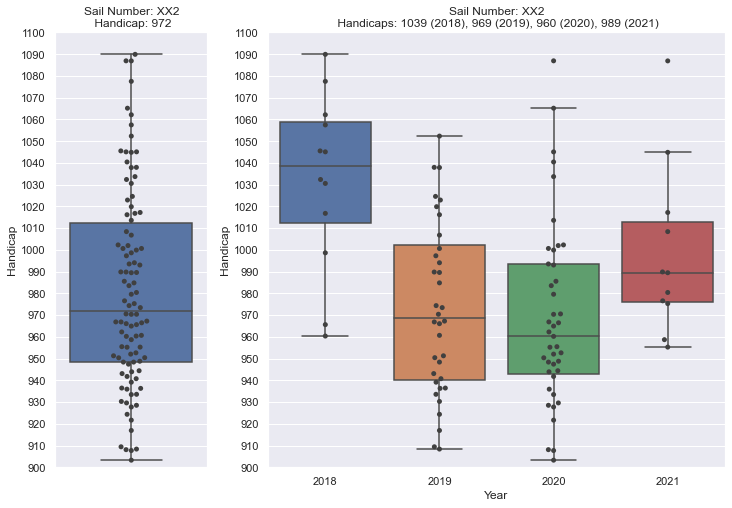

In [10]:
median_handicap = round(handicaps_df['Handicap'].median())
fig1, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 3]})
fig1.set_size_inches(12, 8)
ax1 = sns.boxplot(y='Handicap', data=handicaps_df, showfliers=False, ax=a0)
ax1 = sns.swarmplot(y='Handicap', data=handicaps_df, color=".25", ax=a0)
plot_title = 'Sail Number: ' + target_sailnumber + '\n Handicap: ' + str(median_handicap)
ax1.set(title=plot_title)
ax1.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax1.set(ylim=(900, 1100))

handicaps_by_year = handicaps_df.groupby('Year')['Handicap']

#fig2 = plt.figure()
#fig2.set_size_inches(5, 8)
ax2 = sns.boxplot(x='Year', y='Handicap', data=handicaps_df, showfliers=False, ax=a1)
ax2 = sns.swarmplot(x="Year", y='Handicap', data=handicaps_df, color=".25", ax=a1)
median_handicaps = handicaps_by_year.median().round().astype(int)
plot_title = 'Sail Number: ' + target_sailnumber + '\n Handicaps: '
plot_title += ', '.join((str(median_handicaps.loc[i]) + ' (' + str(i) + ')'
                        for i in median_handicaps.index))
ax2.set(title=plot_title)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax2.set(ylim=(900, 1100))

We see that there's a fairly substantial variation between the upper and lower quartiles, indicating some uncertainty in the true handicap. Some of this variability can be explained by grouping the handicaps by year. The 2018 handicaps are much higher than for other years; this is likely explained by a lack of experience in sailing the boat. For 2019/20/21, the results are more stable, with a median handicap of 969 (2019), 960 (2020), and 989 (2021).

We observe that 2019 and 2020 have significantly more races than 2021, and we can thus expect the 2019/2020 handicaps to be more accurate predictions of the true handicap for those years. 

We take the final handicap to be the median handicap of all results from both the current and previous year; this ensures that enough races are included to give a precise prediction of the handicap, while still allowing the handicap to adjust over time.

The recommended handicap is thus:


In [11]:
final_handicap = round(handicaps_df.query('Year >= 2020')['Handicap'].median())
print('Recommended PY:', final_handicap)

Recommended PY: 967
